# Questão 1

In [24]:
import numpy as np
from numpy import genfromtxt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [3]:
california_data = genfromtxt('californiabin.csv', delimiter=',')
california_data.shape

(2000, 9)

In [4]:
california_data_X = california_data[:, :-1] # (2000,8)
california_data_y = california_data[:, [-1]] # (2000,1) 
california_data_X.shape, california_data_y.shape


((2000, 8), (2000, 1))

## item a) 

#### Split treino/teste (80/20)

In [5]:
from sklearn.model_selection import train_test_split
X_treino_california, X_teste_california, y_treino_california, y_teste_california = train_test_split(california_data_X, california_data_y, test_size=0.2, random_state=1)

#### Funções auxiliares para extrair as métricas do k-fold

In [9]:
def compute_metrics_binary(y_pred, y_val):
    y_val = y_val.ravel()
    accuracy = np.mean(y_pred == y_val)

    tp = np.sum((y_val == 1) & (y_pred == 1))
    fp = np.sum((y_val != 1) & (y_pred == 1))
    fn = np.sum((y_val == 1) & (y_pred != 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        
    return accuracy, recall, precision, f1 

In [10]:
# 10 fold cross validation:
def k_fold_cross_validation(X, y, predicao, k=10):
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    fold_size = len(X) // k

    recalls = []
    precisions = []
    f1s = []
    accuracies = []

    for i in range(k):

        start = i * fold_size
        end = (i + 1) * fold_size if i != k - 1 else len(X)  
        val_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))

        X_treino, y_treino = X[train_indices], y[train_indices]
        X_val, y_val = X[val_indices], y[val_indices]

        mean = X_treino.mean(axis=0)
        std = X_treino.std(axis=0, ddof=1)

        std[std == 0] = 1
        X_treino_norm = (X_treino - mean) / std
        X_val_norm = (X_val - mean) / std

        y_pred = predicao(X_treino_norm, y_treino, X_val_norm)
        
        accuracies_fold, recalls_fold, precisions_fold, f1s_fold = compute_metrics_binary(y_pred, y_val)

        accuracies.append(accuracies_fold)
        recalls.append(recalls_fold)
        precisions.append(precisions_fold)
        f1s.append(f1s_fold)


    return np.array(accuracies), np.array(recalls), np.array(precisions), np.array(f1s)

#### Grid search para C e $\gamma$ (SVM)

In [7]:
# Povoando as listas de valores para gamma e C
c_list = [] 
gamma_list = []
for i in range(-5,16,2):
    c_list.append(2**i)
    gamma_list.append(2**-i)

In [35]:
y_treino_california = y_treino_california.ravel()
best_score_SVM=0
best_params_SVM = {}

for c in c_list:
    for gamma in gamma_list:
        
        def predicaoSVM(X_treino, y_treino, X_teste):
            model = SVC(kernel='rbf', C=c, gamma=gamma)
            model.fit(X_treino, y_treino)
            return model.predict(X_teste)
        
        acc, recalls, precs, f1s = k_fold_cross_validation(X_treino_california, y_treino_california, predicaoSVM, k=10)
        
        avg_acc = np.mean(acc)
        print(f"C={c}, gamma={gamma}, avg_acc={avg_acc:.4f}")

        if avg_acc > best_score_SVM:
            best_score_SVM = avg_acc
            best_params_SVM = {'C': c, 'gamma': gamma}


C=0.03125, gamma=32, avg_acc=0.4888
C=0.03125, gamma=8, avg_acc=0.5075
C=0.03125, gamma=2, avg_acc=0.5212
C=0.03125, gamma=0.5, avg_acc=0.8050
C=0.03125, gamma=0.125, avg_acc=0.8175
C=0.03125, gamma=0.03125, avg_acc=0.7963
C=0.03125, gamma=0.0078125, avg_acc=0.6213
C=0.03125, gamma=0.001953125, avg_acc=0.5075
C=0.03125, gamma=0.00048828125, avg_acc=0.5075
C=0.03125, gamma=0.0001220703125, avg_acc=0.5075
C=0.03125, gamma=3.0517578125e-05, avg_acc=0.5075
C=0.125, gamma=32, avg_acc=0.5075
C=0.125, gamma=8, avg_acc=0.5075
C=0.125, gamma=2, avg_acc=0.7200
C=0.125, gamma=0.5, avg_acc=0.8244
C=0.125, gamma=0.125, avg_acc=0.8325
C=0.125, gamma=0.03125, avg_acc=0.8269
C=0.125, gamma=0.0078125, avg_acc=0.8037
C=0.125, gamma=0.001953125, avg_acc=0.6344
C=0.125, gamma=0.00048828125, avg_acc=0.5075
C=0.125, gamma=0.0001220703125, avg_acc=0.5144
C=0.125, gamma=3.0517578125e-05, avg_acc=0.5219
C=0.5, gamma=32, avg_acc=0.5300
C=0.5, gamma=8, avg_acc=0.6044
C=0.5, gamma=2, avg_acc=0.8175
C=0.5, gamma=0

In [36]:
best_c = best_params_SVM['C']    
best_gamma = best_params_SVM['gamma']
print(f'C: {best_c}\nGamma: {best_gamma}')
print(f'Melhor score de acurácia médio: {best_score_SVM}')

C: 128
Gamma: 0.03125
Melhor score de acurácia médio: 0.8568750000000002


#### Grid search para número de classificadores e profundidade máxima(Random Forest)

In [29]:
n_classificadores = [i*10 for i in range(1,21)]
max_depth = [4, 6, 8, 10, None]

In [32]:
best_score_forest=0
best_params_forest = {}

for n in n_classificadores:
    for depth in max_depth:
        
        def predicaoRandomForest(X_treino, y_treino, X_teste):
            model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=1, n_jobs=-1)
            model.fit(X_treino, y_treino)
            return model.predict(X_teste)
        
        acc, recalls, precs, f1s = k_fold_cross_validation(X_treino_california, y_treino_california, predicaoRandomForest, k=10)
        
        avg_acc = np.mean(acc)
        print(f"n_classificadores={n}, max_depth={depth}, avg_acc={avg_acc:.4f}")

        if avg_acc > best_score_forest:
            best_score_forest = avg_acc
            best_params_forest = {'n_classificadores': n, 'max_depth': depth}


n_classificadores=10, max_depth=4, avg_acc=0.7956
n_classificadores=10, max_depth=6, avg_acc=0.8325
n_classificadores=10, max_depth=8, avg_acc=0.8462
n_classificadores=10, max_depth=10, avg_acc=0.8387
n_classificadores=10, max_depth=None, avg_acc=0.8450
n_classificadores=20, max_depth=4, avg_acc=0.8069
n_classificadores=20, max_depth=6, avg_acc=0.8456
n_classificadores=20, max_depth=8, avg_acc=0.8413
n_classificadores=20, max_depth=10, avg_acc=0.8606
n_classificadores=20, max_depth=None, avg_acc=0.8594
n_classificadores=30, max_depth=4, avg_acc=0.8181
n_classificadores=30, max_depth=6, avg_acc=0.8525
n_classificadores=30, max_depth=8, avg_acc=0.8538
n_classificadores=30, max_depth=10, avg_acc=0.8644
n_classificadores=30, max_depth=None, avg_acc=0.8581
n_classificadores=40, max_depth=4, avg_acc=0.8181
n_classificadores=40, max_depth=6, avg_acc=0.8500
n_classificadores=40, max_depth=8, avg_acc=0.8594
n_classificadores=40, max_depth=10, avg_acc=0.8656
n_classificadores=40, max_depth=None,

In [37]:
best_n = best_params_forest['n_classificadores']    
best_depth = best_params_forest['max_depth']
print(f'n_classificadores: {best_n}\nmax_depth: {best_depth}')
print(f'Melhor score de acurácia médio: {best_score_forest}')

n_classificadores: 90
max_depth: 10
Melhor score de acurácia médio: 0.8706250000000001


## item b) 

#### Normalizando os dados

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_treino_california_norm = scaler.fit_transform(X_treino_california)
X_teste_california_norm = scaler.transform(X_teste_california)

#### Retreinando os modelos vencedores

In [72]:
modelSVM = SVC(kernel='rbf', C=best_c, gamma=best_gamma)
modelSVM.fit(X_treino_california_norm, y_treino_california)
y_pred_svm = modelSVM.predict(X_teste_california_norm)

acc_svm, recalls_svm, precision_svm, f1_svm = compute_metrics_binary(y_pred_svm, y_teste_california)


In [55]:
modelRandomForest = RandomForestClassifier(n_estimators=best_n, max_depth=best_depth, random_state=1, n_jobs=-1)
modelRandomForest.fit(X_treino_california, y_treino_california)
y_pred_forest = modelRandomForest.predict(X_teste_california)

acc_forest, recalls_forest, precision_forest, f1_forest = compute_metrics_binary(y_pred_forest, y_teste_california)


#### Métricas

In [64]:
print("=============== Métricas dos Modelos =============== ")
print(f"Acurácia      - SVM: {acc_svm:.4f} | Random Forest: {acc_forest:.4f}")
print(f"Revocação     - SVM: {recalls_svm:.4f} | Random Forest: {recalls_forest:.4f}")
print(f"Precisão      - SVM: {precision_svm:.4f} | Random Forest: {precision_forest:.4f}")
print(f"F1-Score      - SVM: {f1_svm:.4f} | Random Forest: {f1_forest:.4f}")

=============== Métricas dos Modelos =============== 
Acurácia      - SVM: 0.8375 | Random Forest: 0.8500
Revocação     - SVM: 0.8302 | Random Forest: 0.8302
Precisão      - SVM: 0.8585 | Random Forest: 0.8800
F1-Score      - SVM: 0.8441 | Random Forest: 0.8544


#### Curvas ROC e Precision-Recall

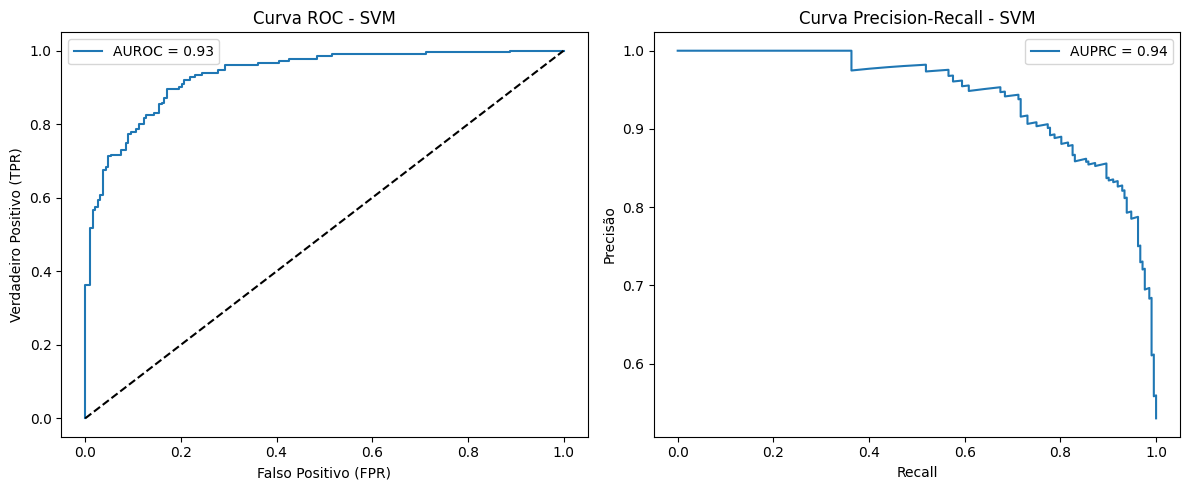

In [77]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_scores_svm = modelSVM.decision_function(X_teste_california_norm)  

fpr, tpr, _ = roc_curve(y_teste_california, y_scores_svm)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_teste_california, y_scores_svm)
prc_auc = average_precision_score(y_teste_california, y_scores_svm)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUROC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.title("Curva ROC - SVM")
plt.legend()

# Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(rec, prec, label=f"AUPRC = {prc_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall - SVM")
plt.legend() 


plt.tight_layout()
plt.show()


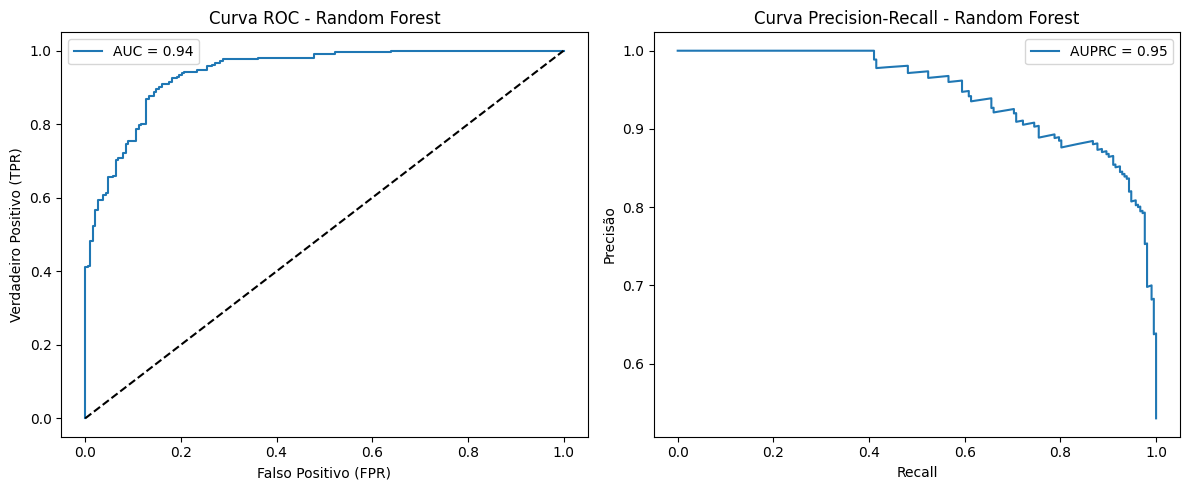

In [79]:
y_scores_forest = modelRandomForest.predict_proba(X_teste_california)[:, 1]

fpr, tpr, _ = roc_curve(y_teste_california, y_scores_forest)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_teste_california, y_scores_forest)
prc_auc = average_precision_score(y_teste_california, y_scores_forest)


plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.title("Curva ROC - Random Forest")
plt.legend()

# Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(rec, prec, label=f"AUPRC = {prc_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall - Random Forest")
plt.legend() 

plt.tight_layout()
plt.show()